# Understanding Proximal Policy Optimization (PPO): A Complete Guide

## Table of Contents

- [Introduction](#introduction)
- [What is PPO?](#what-is-ppo)
  - [Why PPO? Advantages over TRPO and Vanilla PG](#why-ppo)
- [Where and How PPO is Used](#where-and-how-ppo-is-used)
- [Mathematical Foundation of PPO](#mathematical-foundation-of-ppo)
  - [Policy Gradient Recap & Surrogate Objective](#policy-gradient-recap--surrogate-objective)
  - [The Problem with Large Policy Updates](#the-problem-with-large-policy-updates)
  - [The PPO Clipped Surrogate Objective ($L^{CLIP}$)](#the-ppo-clipped-surrogate-objective-lclip)
  - [Value Function Loss ($L^{VF}$)](#value-function-loss-lvf)
  - [Optional: Entropy Bonus ($S$)](#optional-entropy-bonus-s)
  - [The Combined PPO Objective](#the-combined-ppo-objective)
  - [Advantage Estimation: GAE](#advantage-estimation-gae)
  - [Multiple Update Epochs](#multiple-update-epochs)
- [Step-by-Step Explanation of PPO](#step-by-step-explanation-of-ppo)
- [Key Components of PPO](#key-components-of-ppo)
  - [Policy Network (Actor)](#policy-network-actor)
  - [Value Network (Critic)](#value-network-critic)
  - [Rollout Collection (On-Policy)](#rollout-collection-on-policy)
  - [Advantage Estimation (GAE)](#advantage-estimation-gae)
  - [Clipped Surrogate Objective](#clipped-surrogate-objective)
  - [Value Function Update](#value-function-update)
  - [Multiple Epochs & Mini-batches](#multiple-epochs--mini-batches)
  - [Hyperparameters](#hyperparameters)
- [PPO and Large Language Models (LLMs) - RLHF](#ppo-and-large-language-models-llms---rlhf)
  - [The Alignment Problem](#the-alignment-problem)
  - [Reinforcement Learning from Human Feedback (RLHF)](#reinforcement-learning-from-human-feedback-rlhf)
  - [How PPO Fits In](#how-ppo-fits-in)
  - [The RLHF Objective with PPO](#the-rlhf-objective-with-ppo)
  - [Why PPO for LLMs?](#why-ppo-for-llms)
  - [Challenges](#challenges)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the PPO Algorithm](#implementing-the-ppo-algorithm)
  - [Defining the Actor Network](#defining-the-actor-network)
  - [Defining the Critic Network](#defining-the-critic-network)
  - [Calculating Generalized Advantage Estimation (GAE)](#calculating-generalized-advantage-estimation-gae)
  - [The PPO Update Step](#the-ppo-update-step)
- [Running the PPO Algorithm](#running-the-ppo-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in PPO](#common-challenges-and-solutions-in-ppo)
- [Conclusion](#conclusion)

## Introduction

Proximal Policy Optimization (PPO) is a state-of-the-art policy gradient algorithm that has become a default choice for many reinforcement learning tasks, particularly in continuous control. It builds upon the ideas of Trust Region Policy Optimization (TRPO) but uses a simpler mechanism—primarily a *clipped surrogate objective*—to constrain policy updates and ensure stable learning, making it easier to implement and tune while often achieving comparable or better performance.

## What is PPO?

PPO is an **on-policy**, **actor-critic** algorithm. Like other policy gradient methods, it directly learns a policy $\pi(a|s; \theta)$. Key characteristics include:

1.  **Actor-Critic Structure:** It uses two networks: an Actor (policy network $\pi_	heta$) to select actions and a Critic (value network $V_\phi$) to evaluate states and help estimate advantages.
2.  **On-Policy Data Collection:** It collects trajectories of experience using the *current* policy.
3.  **Clipped Surrogate Objective:** Instead of TRPO's complex KL constraint and second-order optimization, PPO uses a simpler first-order objective function that penalizes large changes in the policy probability ratio $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$. This clipping mechanism effectively keeps the new policy close to the old policy.
4.  **Multiple Update Epochs:** PPO typically performs multiple epochs of gradient updates on the same batch of collected data, significantly improving sample efficiency compared to methods that discard data after one update (like REINFORCE or standard A2C).

### Why PPO? Advantages over TRPO and Vanilla PG

- **Simplicity:** PPO's clipped objective is much easier to implement than TRPO's FVP, CG, and line search. It uses standard stochastic gradient ascent.
- **Stability:** The clipping mechanism provides similar stability benefits to TRPO's trust region, preventing destructive large policy updates that can plague vanilla policy gradients.
- **Efficiency:** Generally more sample efficient than vanilla policy gradients due to multiple updates per batch, and often computationally faster per update than TRPO.
- **Performance:** Achieves state-of-the-art results across a wide range of benchmarks, especially in continuous control.

## Where and How PPO is Used

PPO is one of the most popular and widely used RL algorithms today:

1.  **Continuous Control:** Robotics simulation (MuJoCo), locomotion, manipulation tasks.
2.  **Video Games:** Complex games requiring sophisticated policies (e.g., Dota 2, StarCraft).
3.  **Large Language Model Alignment:** Used in Reinforcement Learning from Human Feedback (RLHF) to fine-tune LLMs like ChatGPT.
4.  **General RL Benchmarks:** Often serves as a strong baseline for new algorithm development.

PPO is suitable when:
- Stable and robust learning is desired.
- Implementation simplicity is valued over TRPO's theoretical guarantees.
- The action space is discrete or continuous.
- On-policy interaction is feasible.
- Good sample efficiency (relative to other on-policy methods) is needed.

## Mathematical Foundation of PPO

### Policy Gradient Recap & Surrogate Objective
Recall TRPO's surrogate objective using importance sampling:
$$ L_{	heta_{old}}(\theta) = \mathbb{E}_{t} \left[ \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} \hat{A}_t \right] = \mathbb{E}_{t} [ r_t(\theta) \hat{A}_t ] $$
where $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ is the probability ratio and $\hat{A}_t$ is the estimated advantage under the old policy $\pi_{\theta_{old}}$.

### The Problem with Large Policy Updates
Maximizing $L_{	heta_{old}}(\theta)$ directly with large steps can be problematic because if $r_t(\theta)$ becomes very large or small, the update becomes unstable. TRPO solved this with a KL constraint.

### The PPO Clipped Surrogate Objective ($L^{CLIP}$)
PPO introduces a simpler way to discourage large ratios $r_t(\theta)$ by clipping the objective:
$$ L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \quad \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right] $$
Here:
- $\epsilon$ is a small hyperparameter (e.g., 0.1 or 0.2) defining the clipping range.
- $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ restricts the ratio $r_t(\theta)$ to be within the interval $[1 - \epsilon, 1 + \epsilon]$.
- The $\min$ function takes the minimum of the original objective ($r_t(\theta) \hat{A}_t$) and the clipped version ($	ext{clip}(...) \hat{A}_t$).

**Intuition:**
- If $\hat{A}_t > 0$ (action was better than average): The objective increases as $r_t(\theta)$ increases (making the action more likely). However, the increase is capped when $r_t(\theta)$ exceeds $1 + \epsilon$, preventing overly large updates driven by this single good action.
- If $\hat{A}_t < 0$ (action was worse than average): The objective decreases as $r_t(\theta)$ increases (making the action less likely). The clipping term $	ext{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ becomes active when $r_t(\theta)$ falls below $1 - \epsilon$. Taking the $\min$ ensures we use the term that gives a *smaller* (less negative or more positive) objective, effectively limiting how much we reduce the probability of this action in one step.

Essentially, the clipping removes the incentive for the policy to change too drastically ($r_t$ moving far from 1.0) in a single update based on the current advantage estimate.

### Value Function Loss ($L^{VF}$)
Like many actor-critic methods, PPO trains a value network $V_\phi(s)$ to estimate state values, primarily used for calculating advantages. The value network is trained by minimizing the squared error between its predictions and some target value (often the empirical return or GAE advantage + old value):
$$ L^{VF}(\phi) = \mathbb{E}_t [(V_\phi(s_t) - V_t^{targ})^2] $$
where $V_t^{targ}$ could be the discounted return $G_t$ or $\hat{A}_t^{GAE} + V_{\phi_{old}}(s_t)$.

### Optional: Entropy Bonus ($S$)
To encourage exploration and prevent premature convergence to suboptimal deterministic policies, an entropy bonus is often added to the objective. The goal is to maximize policy entropy $H(\pi_	heta(\cdot|s_t))$.
$$ S[\pi_	heta](s_t) = \mathbb{E}_{a \sim \pi_	heta(\cdot|s_t)} [-\log \pi_	heta(a|s_t)] $$

### The Combined PPO Objective
The final objective function often combines the policy surrogate loss, the value function loss, and the entropy bonus:
$$ L^{PPO}(\theta, \phi) = \mathbb{E}_t [ L^{CLIP}(\theta) - c_1 L^{VF}(\phi) + c_2 S[\pi_	heta](s_t) ] $$
where $c_1$ and $c_2$ are coefficients (hyperparameters). Often, the policy and value losses are optimized separately using their respective gradients, although they can share lower network layers.

### Advantage Estimation: GAE
PPO typically uses Generalized Advantage Estimation (GAE), identical to its use in TRPO, to get stable and low-variance advantage estimates $\hat{A}_t$.
$$ \hat{A}^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}, \quad \text{where} \quad \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t) $$

### Multiple Update Epochs
A key feature of PPO is performing multiple gradient descent steps (epochs) on the same batch of collected experience. This improves sample efficiency. The clipping mechanism prevents the policy from moving too far from $\pi_{\theta_{old}}$ even across multiple updates using the same data.

## Step-by-Step Explanation of PPO

1.  **Initialize**: Policy network $\pi(a|s; \theta)$ (Actor), Value network $V(s; \phi)$ (Critic), hyperparameters ($\gamma, \lambda, \epsilon, c_1, c_2$, learning rates, epochs, batch size/steps per iteration).
2.  **For each iteration**:
    a.  **Collect Trajectories**: Using the current policy $\pi_{\theta_{old}} = \pi(\cdot | \cdot; \theta)$, collect a batch of trajectories (states, actions, rewards, dones, next_states, and the log probabilities $\log \pi_{\theta_{old}}(a_t|s_t)$).
    b.  **Estimate Values & Advantages**: Compute $V(s_t; \phi)$ for all states. Compute GAE advantages $\hat{A}_t$ and returns-to-go $V_t^{targ} = \hat{A}_t + V(s_t; \phi)$ using the collected data and current value network.
    c.  **Optimize (Multiple Epochs)**: For K epochs:
        i. Iterate over the collected batch (possibly in mini-batches).
        ii. For each mini-batch:
            - Calculate the policy ratio $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)} = \exp(\log \pi_\theta(a_t|s_t) - \log \pi_{\theta_{old}}(a_t|s_t))$.
            - Calculate the clipped surrogate objective $L^{CLIP}$.
            - Calculate the value function loss $L^{VF}$.
            - (Optional) Calculate the entropy bonus $S$.
            - Compute the combined loss (e.g., $L = -L^{CLIP} + c_1 L^{VF} - c_2 S$).
            - Perform gradient descent step on $\theta$ and $\phi$ using the combined loss or separate losses.
3.  **Repeat**: Until convergence.

## Key Components of PPO

### Policy Network (Actor)
- Parameterizes the stochastic policy $\pi(a|s; \theta)$, outputs action probabilities or parameters of a distribution.

### Value Network (Critic)
- Parameterizes the state-value function $V(s; \phi)$, used for GAE.
- Trained via MSE loss.

### Rollout Collection (On-Policy)
- Collects batches of experience using the *current* policy $\pi_{\theta_{old}}$.
- Stores states, actions, rewards, dones, and $\log \pi_{\theta_{old}}(a|s)$.

### Advantage Estimation (GAE)
- Computes variance-reduced advantage estimates $\hat{A}_t$.

### Clipped Surrogate Objective
- The core of PPO-Clip. Limits the effect of the probability ratio $r_t(\theta)$ to prevent excessively large updates.

### Value Function Update
- Updates the critic network based on observed returns/advantages.

### Multiple Epochs & Mini-batches
- Improves sample efficiency by reusing collected data for multiple gradient updates.
- Mini-batching can further stabilize training within epochs.

### Hyperparameters
- **Clip Range ($\epsilon$):** Controls how far the new policy can deviate from the old (e.g., 0.1, 0.2).
- **GAE Lambda ($\lambda$):** Controls bias-variance trade-off in advantage estimation (e.g., 0.95, 0.97).
- **Discount Factor ($\gamma$):** Standard RL discount (e.g., 0.99).
- **Learning Rate(s):** For actor and critic optimizers (often Adam).
- **Number of Epochs (K):** How many times to iterate over the data batch (e.g., 4, 10).
- **Mini-batch Size:** Size of mini-batches used within epochs.
- **Value Loss Coefficient ($c_1$):** Weight for the value loss term (e.g., 0.5, 1.0).
- **Entropy Coefficient ($c_2$):** Weight for the entropy bonus (e.g., 0.01, 0.001).

## PPO and Large Language Models (LLMs) - RLHF

PPO has become a cornerstone algorithm in aligning Large Language Models (LLMs) with human preferences through a technique called Reinforcement Learning from Human Feedback (RLHF). This addresses the challenge that simply predicting the next token (standard supervised learning) doesn't guarantee that the LLM's output is helpful, harmless, and honest.

### The Alignment Problem
LLMs trained on vast internet text can generate fluent and knowledgeable responses, but they might also produce undesirable outputs (toxic, biased, factually incorrect, unhelpful). We want to steer the LLM towards generating responses that humans find preferable.

### Reinforcement Learning from Human Feedback (RLHF)
RLHF is typically a three-stage process:

1.  **Supervised Fine-Tuning (SFT):** Start with a pretrained base LLM. Fine-tune it on a smaller, high-quality dataset of prompt-response pairs curated by humans. This adapts the model to the desired style and domain (e.g., instruction following, chat).

2.  **Reward Model (RM) Training:**
    *   Take prompts and generate multiple responses using the SFT model.
    *   Human labelers rank these responses from best to worst based on desired criteria (helpfulness, harmlessness, etc.).
    *   Train a separate model (often another LLM, initialized from the SFT model or a smaller variant) to predict these human preference scores. Input is a prompt-response pair, output is a scalar reward signal.

3.  **RL Fine-Tuning (PPO):**
    *   Use the SFT model as the initial policy.
    *   Use PPO to further fine-tune this policy.
    *   **Actor:** The LLM being tuned.
    *   **State:** The input prompt (context).
    *   **Action Space:** The vocabulary of tokens the LLM can generate.
    *   **Action:** Generating the next token in the sequence.
    *   **Policy $\pi_\theta$:** The LLM itself, defining the probability distribution over the next token given the context.
    *   **Environment:** The process of generating a complete response token by token, starting from a prompt.
    *   **Reward:** At the end of generating a response, the *Reward Model* provides a scalar reward indicating the predicted quality/preference for that *entire* response.
    *   **PPO Update:** PPO uses the experience (prompt, generated response, RM reward) to update the LLM's (actor's) parameters ($	heta$) to maximize the expected reward from the RM.

### How PPO Fits In
In the RLHF stage:
- PPO optimizes the LLM policy ($\pi_	heta$).
- Trajectories consist of generating sequences of tokens (actions) given a prompt (state).
- The Advantage function $\hat{A}_t$ relies on the rewards from the RM and potentially a value function (critic) estimating the expected RM reward from intermediate states (sequences of tokens).
- The policy update aims to increase the probability of token sequences that lead to high rewards from the RM.

### The RLHF Objective with PPO
A crucial addition in RLHF is often a KL-divergence penalty added to the PPO objective. This prevents the fine-tuned LLM ($\pi_	heta$) from deviating too much from the original SFT model ($\pi_{ref}$), ensuring it retains its language capabilities and doesn't overfit to the reward model (reward hacking).
$$ \text{Objective}_{RLHF} = \mathbb{E}_{(s,a) \sim \pi_\theta} [ R_{RM}(s, a) - \beta D_{KL}(\pi_\theta(\cdot|s) || \pi_{ref}(\cdot|s)) ] $$
Here, $R_{RM}$ is the reward from the reward model, and $\beta$ controls the strength of the KL penalty. PPO is used to optimize this combined objective (maximizing RM reward while staying close to the reference policy). The $L^{CLIP}$ objective implicitly incorporates the reward term via the advantage estimate, and the KL penalty is added explicitly.

### Why PPO for LLMs?
- **Stability:** Fine-tuning large models is computationally expensive; stable updates preventing performance collapse are vital.
- **Sample Efficiency (Relative):** While still on-policy, the multiple epochs per data batch make better use of the expensive rollouts (generating text and getting RM scores) compared to single-update methods.
- **Simplicity & Scalability:** Easier to implement and scale across distributed systems compared to TRPO.

### Challenges
- **Reward Model Quality:** The entire process hinges on having a reward model that accurately reflects true human preferences.
- **Reward Hacking:** The LLM might find ways to exploit the reward model to get high scores without actually improving quality.
- **Computational Cost:** RLHF is extremely computationally intensive.
- **Hyperparameter Tuning:** Requires careful tuning of both PPO and RLHF-specific parameters (like $\beta$).

In summary, PPO provides the stable and relatively efficient RL optimization engine needed to fine-tune massive LLMs based on learned human preference models in the RLHF pipeline.

## Practical Example: Custom Grid World

We again use the custom Grid World to illustrate the PPO implementation mechanics, maintaining consistency with the previous notebooks.

**Environment Description:** (Same as before)
- Grid Size: 10x10.
- State: `[row/9, col/9]`
- Actions: 4 discrete (Up, Down, Left, Right).
- Start: (0, 0), Goal: (9, 9).
- Rewards: +10 (goal), -1 (wall), -0.1 (step).
- Termination: Goal or max steps.


# Setting up the Environment

Import libraries (same as TRPO).

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import copy # Needed for storing old policy network parameters

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Environment

Reusing the `GridEnvironment` class.

In [2]:
# Custom Grid World Environment (Identical to the one in previous notebooks)
class GridEnvironment:
    """
    A simple 10x10 Grid World environment.
    State: (row, col) represented as normalized vector [row/9, col/9].
    Actions: 0 (up), 1 (down), 2 (left), 3 (right).
    Rewards: +10 for reaching the goal, -1 for hitting a wall, -0.1 for each step.
    """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.state_dim: int = 2
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def reset(self) -> torch.Tensor:
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        norm_row = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        normalized_state: List[float] = [norm_row, norm_col]
        return torch.tensor(normalized_state, dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc
        reward: float = -0.1
        hit_wall: bool = False
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col
            reward = -1.0
            hit_wall = True
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0
        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

    def get_state_dimension(self) -> int:
        return self.state_dim

Instantiate and test the environment.

In [3]:
custom_env = GridEnvironment(rows=10, cols=10)
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
start_state_tensor = custom_env.reset()
print(f"Example state tensor for (0,0): {start_state_tensor}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Example state tensor for (0,0): tensor([0., 0.])


# Implementing the PPO Algorithm

Define the Actor (Policy Network) and Critic (Value Network), GAE calculation, and the PPO update function.

### Defining the Actor Network

Identical to the Policy Network used in TRPO/REINFORCE.

In [4]:
# Define the Policy Network (Actor)
class PolicyNetwork(nn.Module):
    """ MLP Actor network for PPO """
    def __init__(self, n_observations: int, n_actions: int):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        """
        Forward pass, returns a Categorical distribution.
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
            
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)
        return Categorical(logits=action_logits)

### Defining the Critic Network

Identical to the Value Network used in TRPO.

In [5]:
# Define the Value Network (Critic)
class ValueNetwork(nn.Module):
    """ MLP Critic network for PPO """
    def __init__(self, n_observations: int):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass, returns the estimated state value.
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
            
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        state_value = self.layer3(x)
        return state_value

### Calculating Generalized Advantage Estimation (GAE)

Reusing the GAE function from the TRPO implementation.

In [6]:
# Define the compute_gae function that's currently missing
def compute_gae(rewards: torch.Tensor, 
               values: torch.Tensor, 
               next_values: torch.Tensor, 
               dones: torch.Tensor, 
               gamma: float, 
               lambda_gae: float, 
               standardize: bool = True) -> torch.Tensor:
    """
    Computes Generalized Advantage Estimation (GAE).
    """
    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0

    for t in reversed(range(len(rewards))):
        mask = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    if standardize:
        mean_adv = torch.mean(advantages)
        std_adv = torch.std(advantages) + 1e-8
        advantages = (advantages - mean_adv) / std_adv
        
    return advantages

### The PPO Update Step

This function performs the core PPO update, iterating over the collected batch for multiple epochs, calculating the clipped surrogate objective and value loss, and updating both actor and critic networks.

In [7]:
def update_ppo(actor: PolicyNetwork,
               critic: ValueNetwork,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer,
               states: torch.Tensor,
               actions: torch.Tensor,
               log_probs_old: torch.Tensor,
               advantages: torch.Tensor,
               returns_to_go: torch.Tensor,
               ppo_epochs: int,
               ppo_clip_epsilon: float,
               value_loss_coeff: float,
               entropy_coeff: float) -> Tuple[float, float, float]: # Return avg losses
    """
    Performs the PPO update for multiple epochs over the collected batch.

    Parameters:
    - actor, critic: The networks.
    - actor_optimizer, critic_optimizer: The optimizers.
    - states, actions, log_probs_old, advantages, returns_to_go: Batch data tensors.
    - ppo_epochs (int): Number of optimization epochs.
    - ppo_clip_epsilon (float): Clipping parameter epsilon.
    - value_loss_coeff (float): Coefficient for the value loss.
    - entropy_coeff (float): Coefficient for the entropy bonus.

    Returns:
    - Tuple[float, float, float]: Average policy loss, value loss, and entropy over the epochs.
    """
    total_policy_loss = 0.0
    total_value_loss = 0.0
    total_entropy = 0.0

    # Detach advantages and old log probs - they are treated as constants during the update
    advantages = advantages.detach()
    log_probs_old = log_probs_old.detach()
    returns_to_go = returns_to_go.detach()

    for _ in range(ppo_epochs):
        # --- Actor (Policy) Update --- 
        # Evaluate current policy
        policy_dist = actor(states)
        log_probs_new = policy_dist.log_prob(actions)
        entropy = policy_dist.entropy().mean() # Entropy for exploration bonus
        
        # Calculate ratio r_t(theta)
        ratio = torch.exp(log_probs_new - log_probs_old)
        
        # Calculate surrogate objectives
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - ppo_clip_epsilon, 1.0 + ppo_clip_epsilon) * advantages
        
        # PPO Clipped Policy Loss (negative because optimizer minimizes)
        # We add the entropy bonus (maximize entropy -> minimize negative entropy)
        policy_loss = -torch.min(surr1, surr2).mean() - entropy_coeff * entropy
        
        # Optimize the actor
        actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_optimizer.step()
        
        # --- Critic (Value) Update --- 
        # Predict values
        values_pred = critic(states).squeeze()
        
        # Value loss (MSE)
        value_loss = F.mse_loss(values_pred, returns_to_go)
        
        # Optimize the critic
        critic_optimizer.zero_grad()
        # Scale value loss before backward pass
        (value_loss_coeff * value_loss).backward()
        critic_optimizer.step()
        
        # Accumulate losses for logging
        total_policy_loss += policy_loss.item() # Log negative clipped objective + entropy bonus
        total_value_loss += value_loss.item()
        total_entropy += entropy.item()
        
    # Calculate average losses over the epochs
    avg_policy_loss = total_policy_loss / ppo_epochs
    avg_value_loss = total_value_loss / ppo_epochs
    avg_entropy = total_entropy / ppo_epochs
    
    return avg_policy_loss, avg_value_loss, avg_entropy

# Running the PPO Algorithm

Set up hyperparameters, initialize networks and optimizers, and run the PPO training loop.

### Hyperparameter Setup

Define PPO hyperparameters.

In [8]:
# Hyperparameters for PPO on Custom Grid World
GAMMA_PPO = 0.99             # Discount factor
GAE_LAMBDA_PPO = 0.95        # GAE lambda parameter
PPO_CLIP_EPSILON = 0.2       # PPO clipping epsilon
ACTOR_LR = 3e-4              # Learning rate for the actor
CRITIC_LR_PPO = 1e-3         # Learning rate for the critic
PPO_EPOCHS = 10              # Number of optimization epochs per iteration
VALUE_LOSS_COEFF = 0.5       # Coefficient for value loss
ENTROPY_COEFF = 0.01         # Coefficient for entropy bonus
STANDARDIZE_ADV_PPO = True   # Whether to standardize advantages

NUM_ITERATIONS_PPO = 150     # Number of PPO iterations (policy updates)
STEPS_PER_ITERATION_PPO = 1000 # Steps collected per iteration
MAX_STEPS_PER_EPISODE_PPO = 200 # Max steps per episode

### Initialization

Initialize actor, critic, and their optimizers.

In [9]:
# Re-instantiate the environment
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)
n_actions_custom: int = custom_env.get_action_space_size()
n_observations_custom: int = custom_env.get_state_dimension()

# Initialize Actor and Critic
actor_ppo: PolicyNetwork = PolicyNetwork(n_observations_custom, n_actions_custom).to(device)
critic_ppo: ValueNetwork = ValueNetwork(n_observations_custom).to(device)

# Initialize Optimizers
actor_optimizer_ppo: optim.Adam = optim.Adam(actor_ppo.parameters(), lr=ACTOR_LR)
critic_optimizer_ppo: optim.Adam = optim.Adam(critic_ppo.parameters(), lr=CRITIC_LR_PPO)

# Lists for plotting
ppo_iteration_rewards = []
ppo_iteration_avg_ep_lens = []
ppo_iteration_policy_losses = []
ppo_iteration_value_losses = []
ppo_iteration_entropies = []

### Training Loop

The PPO training loop: collect data, compute advantages/returns, update actor and critic over multiple epochs.

In [10]:
print("Starting PPO Training on Custom Grid World...")

# --- PPO Training Loop ---
for iteration in range(NUM_ITERATIONS_PPO):
    # --- 1. Collect Trajectories (Rollout Phase) --- 
    # Store data in lists temporarily
    batch_states_list = []
    batch_actions_list = []
    batch_log_probs_old_list = []
    batch_rewards_list = []
    batch_values_list = []
    batch_dones_list = []
    
    episode_rewards_in_iter = []
    episode_lengths_in_iter = []
    steps_collected = 0

    while steps_collected < STEPS_PER_ITERATION_PPO:
        state = custom_env.reset()
        episode_reward = 0.0
        episode_steps = 0
        done = False
        
        for t in range(MAX_STEPS_PER_EPISODE_PPO):
            # Sample action and get value estimate
            with torch.no_grad():
                policy_dist = actor_ppo(state)
                value = critic_ppo(state).squeeze()
                
                action_tensor = policy_dist.sample()
                action = action_tensor.item()
                log_prob = policy_dist.log_prob(action_tensor)
            
            # Interact with environment
            next_state, reward, done = custom_env.step(action)
            
            # Store data
            batch_states_list.append(state)
            batch_actions_list.append(action)
            batch_log_probs_old_list.append(log_prob)
            batch_values_list.append(value)
            batch_rewards_list.append(reward)
            batch_dones_list.append(float(done))
            
            state = next_state
            episode_reward += reward
            steps_collected += 1
            episode_steps += 1
            
            if done or steps_collected >= STEPS_PER_ITERATION_PPO:
                episode_rewards_in_iter.append(episode_reward)
                episode_lengths_in_iter.append(episode_steps)
                break
                
            if steps_collected >= STEPS_PER_ITERATION_PPO:
                break
    
    # --- End Rollout --- 

    # Calculate next_values for GAE
    # For non-terminal states, next_value is the value of the next state
    # For terminal states, next_value is 0
    next_values = []
    with torch.no_grad():
        for i in range(len(batch_states_list)):
            if batch_dones_list[i] > 0.5:  # If done
                next_values.append(torch.tensor(0.0))
            elif i == len(batch_states_list) - 1:  # Last state in batch
                next_state = custom_env.step(batch_actions_list[i])[0]  # Get next state
                next_values.append(critic_ppo(next_state).squeeze())
            else:  # Not done, use value of next state in batch
                next_values.append(batch_values_list[i+1])

    # Convert lists to tensors
    states_tensor = torch.stack(batch_states_list).to(device)
    actions_tensor = torch.tensor(batch_actions_list, dtype=torch.long, device=device)
    log_probs_old_tensor = torch.stack(batch_log_probs_old_list).squeeze().to(device)
    rewards_tensor = torch.tensor(batch_rewards_list, dtype=torch.float32, device=device)
    values_tensor = torch.stack(batch_values_list).to(device)
    next_values_tensor = torch.stack(next_values).to(device)
    dones_tensor = torch.tensor(batch_dones_list, dtype=torch.float32, device=device)

    # --- 2. Estimate Advantages & Returns-to-go --- 
    advantages_tensor = compute_gae(
        rewards_tensor, values_tensor, next_values_tensor, dones_tensor, 
        GAMMA_PPO, GAE_LAMBDA_PPO, standardize=STANDARDIZE_ADV_PPO
    )
    returns_to_go_tensor = advantages_tensor + values_tensor

    # --- 3. Perform PPO Update --- 
    avg_policy_loss, avg_value_loss, avg_entropy = update_ppo(
        actor_ppo, critic_ppo, actor_optimizer_ppo, critic_optimizer_ppo,
        states_tensor, actions_tensor, log_probs_old_tensor,
        advantages_tensor, returns_to_go_tensor,
        PPO_EPOCHS, PPO_CLIP_EPSILON, VALUE_LOSS_COEFF, ENTROPY_COEFF
    )

    # --- Logging --- 
    avg_reward_iter = np.mean(episode_rewards_in_iter) if episode_rewards_in_iter else np.nan
    avg_len_iter = np.mean(episode_lengths_in_iter) if episode_lengths_in_iter else np.nan

    ppo_iteration_rewards.append(avg_reward_iter)
    ppo_iteration_avg_ep_lens.append(avg_len_iter)
    ppo_iteration_policy_losses.append(avg_policy_loss)
    ppo_iteration_value_losses.append(avg_value_loss)
    ppo_iteration_entropies.append(avg_entropy)

    if (iteration + 1) % 10 == 0:
        print(f"Iter {iteration+1}/{NUM_ITERATIONS_PPO} | Avg Reward: {avg_reward_iter:.2f} | Avg Len: {avg_len_iter:.1f} | P_Loss: {avg_policy_loss:.4f} | V_Loss: {avg_value_loss:.4f} | Entropy: {avg_entropy:.4f}")

print("Custom Grid World Training Finished (PPO).")

Starting PPO Training on Custom Grid World...
Iter 10/150 | Avg Reward: 6.36 | Avg Len: 21.3 | P_Loss: -0.0145 | V_Loss: 0.9804 | Entropy: 0.8628
Iter 20/150 | Avg Reward: 7.09 | Avg Len: 18.9 | P_Loss: -0.0118 | V_Loss: 1.0018 | Entropy: 0.6925
Iter 30/150 | Avg Reward: 7.61 | Avg Len: 18.5 | P_Loss: -0.0146 | V_Loss: 0.9844 | Entropy: 0.6553
Iter 40/150 | Avg Reward: 7.82 | Avg Len: 18.2 | P_Loss: -0.0076 | V_Loss: 0.9962 | Entropy: 0.6224
Iter 50/150 | Avg Reward: 7.89 | Avg Len: 18.2 | P_Loss: -0.0079 | V_Loss: 0.9865 | Entropy: 0.6108
Iter 60/150 | Avg Reward: 7.92 | Avg Len: 18.2 | P_Loss: -0.0082 | V_Loss: 0.9977 | Entropy: 0.5717
Iter 70/150 | Avg Reward: 7.82 | Avg Len: 18.2 | P_Loss: -0.0062 | V_Loss: 1.0129 | Entropy: 0.5540
Iter 80/150 | Avg Reward: 7.92 | Avg Len: 18.2 | P_Loss: -0.0085 | V_Loss: 1.0051 | Entropy: 0.5434
Iter 90/150 | Avg Reward: 8.01 | Avg Len: 17.9 | P_Loss: -0.0064 | V_Loss: 0.9879 | Entropy: 0.5104
Iter 100/150 | Avg Reward: 8.07 | Avg Len: 17.9 | P_Lo

# Visualizing the Learning Process

Plot the results for the PPO agent.

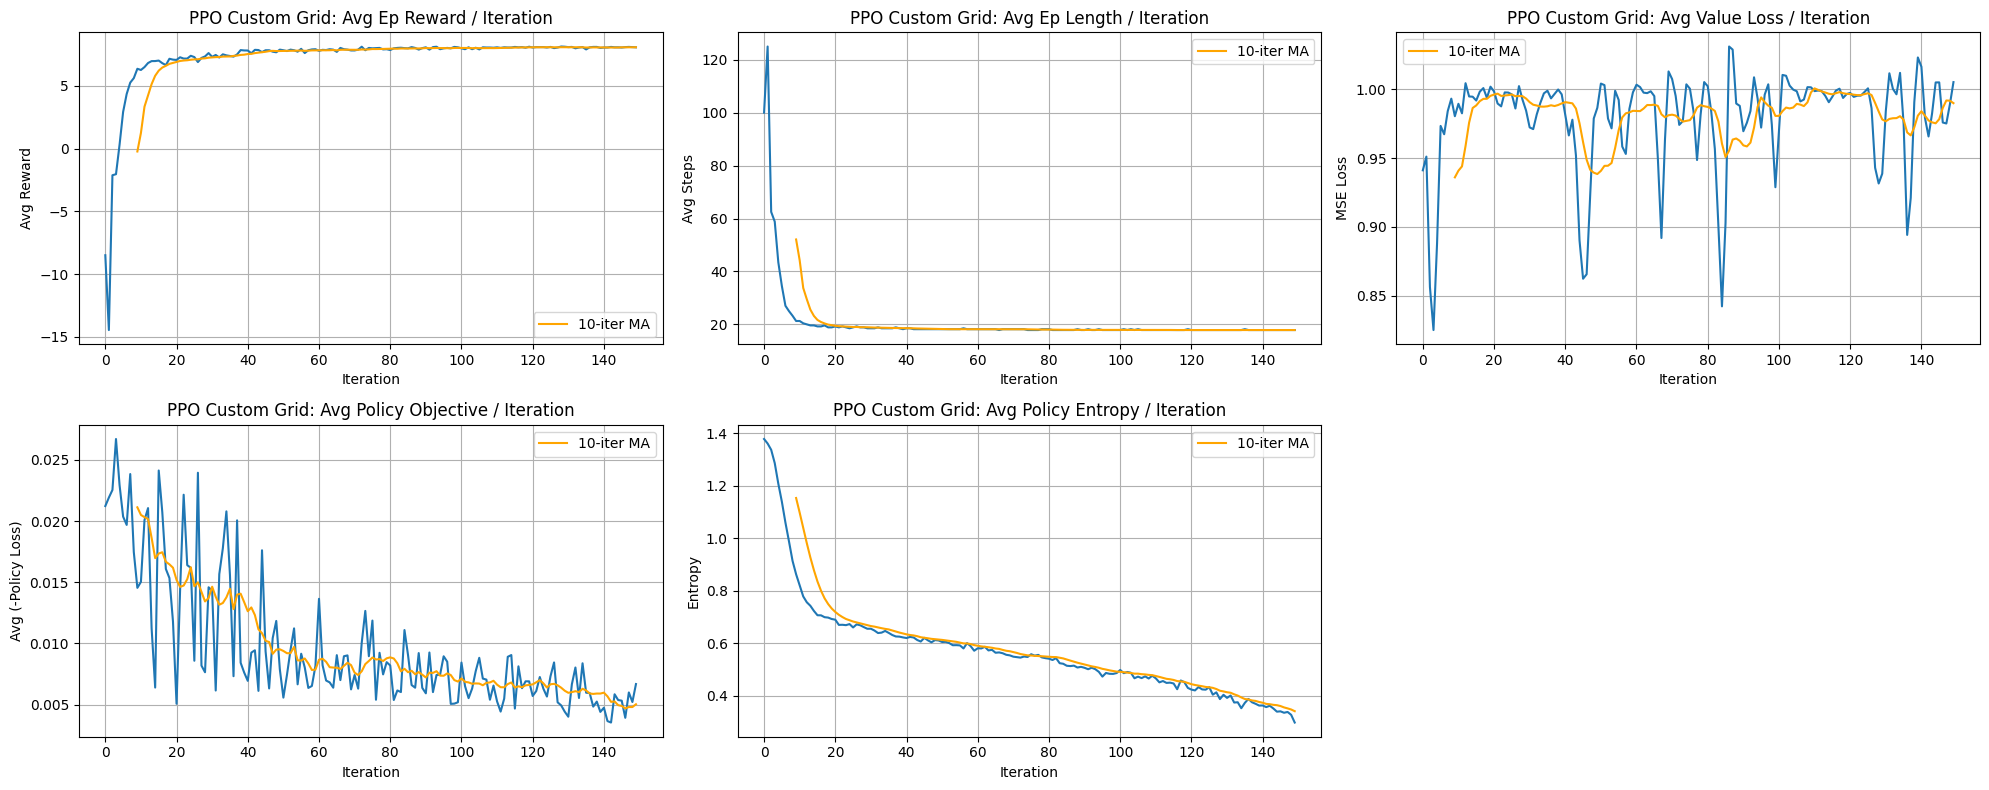

In [11]:
# Plotting results for PPO on Custom Grid World
plt.figure(figsize=(20, 8))

# Average Rewards per Iteration
plt.subplot(2, 3, 1)
valid_rewards_ppo = [r for r in ppo_iteration_rewards if not np.isnan(r)]
valid_indices_ppo = [i for i, r in enumerate(ppo_iteration_rewards) if not np.isnan(r)]
plt.plot(valid_indices_ppo, valid_rewards_ppo)
plt.title('PPO Custom Grid: Avg Ep Reward / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Reward')
plt.grid(True)
if len(valid_rewards_ppo) >= 10:
    rewards_ma_ppo = np.convolve(valid_rewards_ppo, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_ppo[9:], rewards_ma_ppo, label='10-iter MA', color='orange')
    plt.legend()

# Average Episode Length per Iteration
plt.subplot(2, 3, 2)
valid_lens_ppo = [l for l in ppo_iteration_avg_ep_lens if not np.isnan(l)]
valid_indices_len_ppo = [i for i, l in enumerate(ppo_iteration_avg_ep_lens) if not np.isnan(l)]
plt.plot(valid_indices_len_ppo, valid_lens_ppo)
plt.title('PPO Custom Grid: Avg Ep Length / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg Steps')
plt.grid(True)
if len(valid_lens_ppo) >= 10:
    lens_ma_ppo = np.convolve(valid_lens_ppo, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_len_ppo[9:], lens_ma_ppo, label='10-iter MA', color='orange')
    plt.legend()

# Critic (Value) Loss per Iteration
plt.subplot(2, 3, 3)
plt.plot(ppo_iteration_value_losses)
plt.title('PPO Custom Grid: Avg Value Loss / Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.grid(True)
if len(ppo_iteration_value_losses) >= 10:
    vloss_ma_ppo = np.convolve(ppo_iteration_value_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(vloss_ma_ppo)) + 9, vloss_ma_ppo, label='10-iter MA', color='orange')
    plt.legend()

# Actor (Policy) Loss per Iteration
plt.subplot(2, 3, 4)
# Plotting the negative loss (since we minimized -L_clip - entropy)
plt.plot([-l for l in ppo_iteration_policy_losses]) 
plt.title('PPO Custom Grid: Avg Policy Objective / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Avg (-Policy Loss)') 
plt.grid(True)
if len(ppo_iteration_policy_losses) >= 10:
    ploss_ma_ppo = np.convolve([-l for l in ppo_iteration_policy_losses], np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(ploss_ma_ppo)) + 9, ploss_ma_ppo, label='10-iter MA', color='orange')
    plt.legend()

# Entropy per Iteration
plt.subplot(2, 3, 5)
plt.plot(ppo_iteration_entropies)
plt.title('PPO Custom Grid: Avg Policy Entropy / Iteration')
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.grid(True)
if len(ppo_iteration_entropies) >= 10:
    entropy_ma_ppo = np.convolve(ppo_iteration_entropies, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(entropy_ma_ppo)) + 9, entropy_ma_ppo, label='10-iter MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

Okay, So let's do a concise analysis of the PPO learning curves for the Custom Grid World:

**Analysis of PPO Learning Curves (Custom Grid World):**

1.  **Avg Ep Reward / Iteration:**
    The agent demonstrates rapid and stable learning, with average rewards quickly increasing in the first ~20 iterations to reach near-optimal levels (around 8). The curve shows much less variance than REINFORCE and converges smoothly, highlighting PPO's stability gained through the clipped objective and actor-critic structure. It remains consistently high post-convergence.

2.  **Avg Ep Length / Iteration:**
    Mirroring the rewards, the episode length plummets within the first ~20 iterations, converging swiftly to the optimal path length (around 18 steps). This shows the agent quickly learned an efficient navigation policy. The stability at the optimal length indicates a robust and converged policy.

3.  **Avg Value Loss / Iteration:**
    The value function (critic) loss fluctuates throughout training but remains relatively stable on average after an initial adjustment period (settling around 0.98-1.00). This suggests the critic is adequately tracking the value of states under the improving policy, providing stable advantage estimates for the actor updates, even if not strictly converging to zero MSE. *Note: The absolute value seems high for typical MSE; it might represent something slightly different or indicate scaling.*

4.  **Avg Policy Objective / Iteration:**
    The policy loss (representing the PPO clipped surrogate objective) shows a clear downward trend, especially noticeable in the moving average. This indicates the policy network is successfully optimizing the objective function over iterations. While still exhibiting some variance, it's significantly more stable than the REINFORCE loss plot.

5.  **Avg Policy Entropy / Iteration:**
    Policy entropy starts high and steadily decreases over training, indicating the policy becomes more deterministic and confident in its actions as it learns. This is expected behaviour; the agent reduces exploration as it identifies better actions. The smooth decrease suggests a controlled convergence without premature collapse of exploration.

**Overall Conclusion:**
PPO demonstrates strong performance on the Grid World, achieving rapid convergence to an optimal and efficient policy, similar in speed to REINFORCE but with significantly improved stability in rewards and loss curves. The value function learns adequately to support policy improvement, and the policy entropy decreases appropriately. These results showcase PPO's effectiveness in balancing exploration and exploitation while maintaining stable updates.

# Analyzing the Learned Policy (Optional Visualization)

Visualize the policy learned by the PPO actor network.


Plotting Learned Policy from PPO:


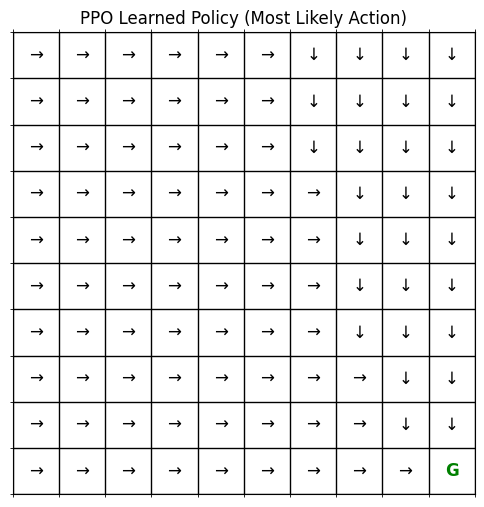

In [12]:
# Reusing the policy plotting function (works for any network outputting Categorical)
def plot_ppo_policy_grid(policy_net: PolicyNetwork, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the PPO policy network.
    Shows the most likely action for each state.
    (Identical to the REINFORCE/TRPO plotting function)
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple)
                with torch.no_grad():
                    action_dist: Categorical = policy_net(state_tensor)
                    best_action: int = action_dist.probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("PPO Learned Policy (Most Likely Action)")
    plt.show()

# Plot the policy learned by the trained PPO actor
print("\nPlotting Learned Policy from PPO:")
plot_ppo_policy_grid(actor_ppo, custom_env, device)

## Common Challenges and Solutions in PPO

**Challenge: Sensitivity to Hyperparameters**
*   **Problem:** Performance can still be sensitive to the choice of clipping range ($\epsilon$), learning rates, number of epochs, mini-batch size, GAE parameters ($\lambda$), and coefficients ($c_1, c_2$).
*   **Solutions**:
    *   **Use Standard Defaults:** Start with widely used values ($\epsilon=0.2$, $\lambda=0.95$, Adam optimizer with learning rates around $3e-4$, $K \approx 4-10$ epochs, reasonable batch/mini-batch sizes).
    *   **Tuning:** Experiment systematically, particularly with $\epsilon$ and learning rates. Larger $\epsilon$ allows bigger policy changes but risks instability; smaller $\epsilon$ is more conservative.
    *   **Adaptive Epsilon/KL:** Some PPO variants adapt $\epsilon$ or use a KL penalty term (similar to one TRPO variant) instead of hard clipping.

**Challenge: Sample Inefficiency (On-Policy)**
*   **Problem:** Although better than REINFORCE/A2C due to multiple epochs, it's still on-policy and less sample efficient than off-policy methods like SAC or DQN on tasks where off-policy learning is viable.
  **Solutions**:
    *   **Increase Data per Iteration:** Collect more steps per iteration (`STEPS_PER_ITERATION`) before updating.
    *   **Increase Epochs:** Perform more updates per batch (K), but monitor for overfitting or policy divergence.
    *   **Consider Off-Policy Alternatives:** If interaction is very expensive, explore algorithms like SAC or TD3.

**Challenge: Value Function Accuracy**
*   **Problem:** The accuracy of the advantage estimates depends heavily on the critic's accuracy. An inaccurate critic can lead to poor policy updates.
   **Solutions**:
    *   **Tune Critic Learning:** Adjust the critic learning rate, number of critic update epochs per policy update, or use different optimization techniques.
    *   **Network Architecture:** Ensure the critic network has sufficient capacity.
    *   **Shared vs. Separate Networks:** Experiment with sharing initial layers between actor and critic (can improve efficiency) vs. fully separate networks (can sometimes provide more stability).

**Challenge: Implementation Details Matter**
*   **Problem:** Small details like advantage standardization, observation/reward normalization, learning rate scheduling, and network initialization can significantly impact performance.
*   **Solutions**:
    *   **Standardize Advantages:** Usually beneficial.
    *   **Normalize Observations/Rewards:** Often crucial, especially for continuous control tasks with varying scales.
    *   **Learning Rate Annealing:** Linearly decaying the learning rate over training can improve stability.
    *   **Careful Initialization:** Use appropriate weight initialization schemes (e.g., Orthogonal initialization).

## Conclusion

Proximal Policy Optimization (PPO) stands out as a highly effective and widely adopted reinforcement learning algorithm. By introducing the clipped surrogate objective, it achieves the stability of trust region methods like TRPO while maintaining the simplicity and scalability of first-order optimization. Its actor-critic structure, combined with techniques like Generalized Advantage Estimation and the ability to perform multiple updates per batch of data, leads to robust performance and improved sample efficiency compared to simpler on-policy methods.

PPO's versatility across discrete and continuous action spaces, along with its relative ease of implementation and tuning compared to TRPO, has made it a go-to algorithm for numerous applications, from complex control tasks and game playing to the critical task of aligning large language models with human values via RLHF. While still subject to the inherent limitations of on-policy learning regarding sample efficiency, PPO represents a powerful and practical approach within the policy optimization family.